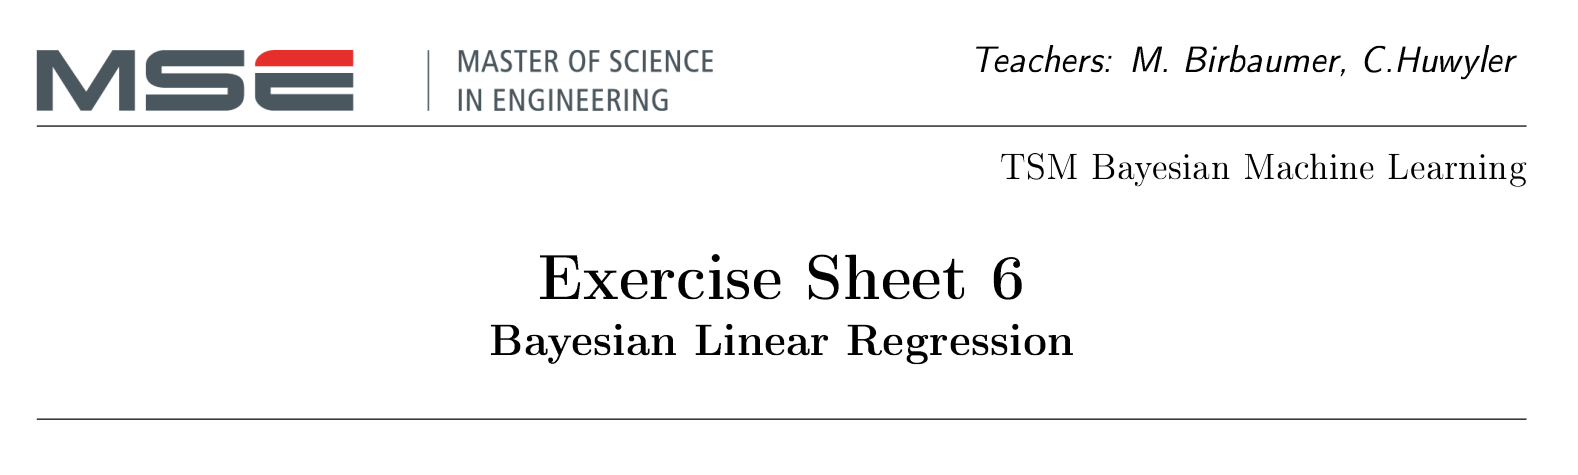

# Solutions

Import necessary libraries:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz
import pymc as pm
import arviz as az
import bambi as bmb
plt.rcParams["figure.figsize"] = (8,3)
plt.style.use('ggplot')
np.random.seed(1337) # for consistency

## Exercise 1

In [2]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


### a)

\begin{eqnarray}
\beta_0 &\sim& N(\theta_0, \tau_0^2)\\
\beta_1 &\sim& N(\theta_1, \tau_1^2)\\
\sigma &\sim& \text{Exp}(1/l) \quad (\text{or something similar, as long as its only over positive values})\\
y|\beta_0, \beta_1, \sigma &\sim& N(\beta_0 + \beta_1 \, x, \sigma^2)
\end{eqnarray}

### b)

In [3]:
credit_model1 = bmb.Model("Balance ~ Limit", data=credit_data, family="gaussian")
credit_trace1 = credit_model1.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


In [4]:
credit_model1.backend.model

    sigma ~ HalfStudentT(4, 459)
Intercept ~ Normal(520, 2.62e+03)
    Limit ~ Normal(0, 0.498)
       mu ~ Deterministic(f(Limit, Intercept))
  Balance ~ Normal(mu, sigma)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: t_rv{"(),(),()->()"}(*0-<RandomGeneratorType>, *1-<NoneTypeT>, *2-<Scalar(float64, shape=())>, 0.0, *3-<Scalar(float64, shape=())>)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/pytensor/tensor/random/rewr

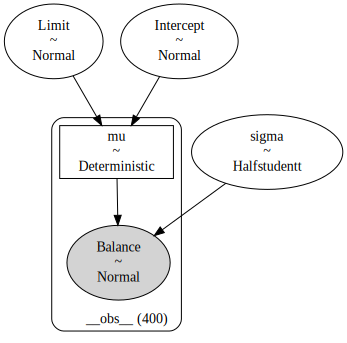

In [5]:
credit_model1.graph() # may lead to warnings or errors depending on what versions you use / what packages you have installed

Bambi uses a half Student's $t$ distribution and I proposed an exponential distribution above. Both only go over positive values and since they are weak there should not be a big difference in the resulting posterior.

### c)

In [6]:
pm.summary( credit_trace1, hdi_prob=0.95 )

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,234.118,8.531,218.161,251.617,0.079,0.103,11578.0,6027.0,1.0
Intercept,-292.768,27.188,-345.843,-239.523,0.252,0.301,11641.0,6002.0,1.0
Limit,0.172,0.005,0.162,0.182,0.000,0.000,12041.0,6312.0,1.0


array([<Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'Limit'}>], dtype=object)

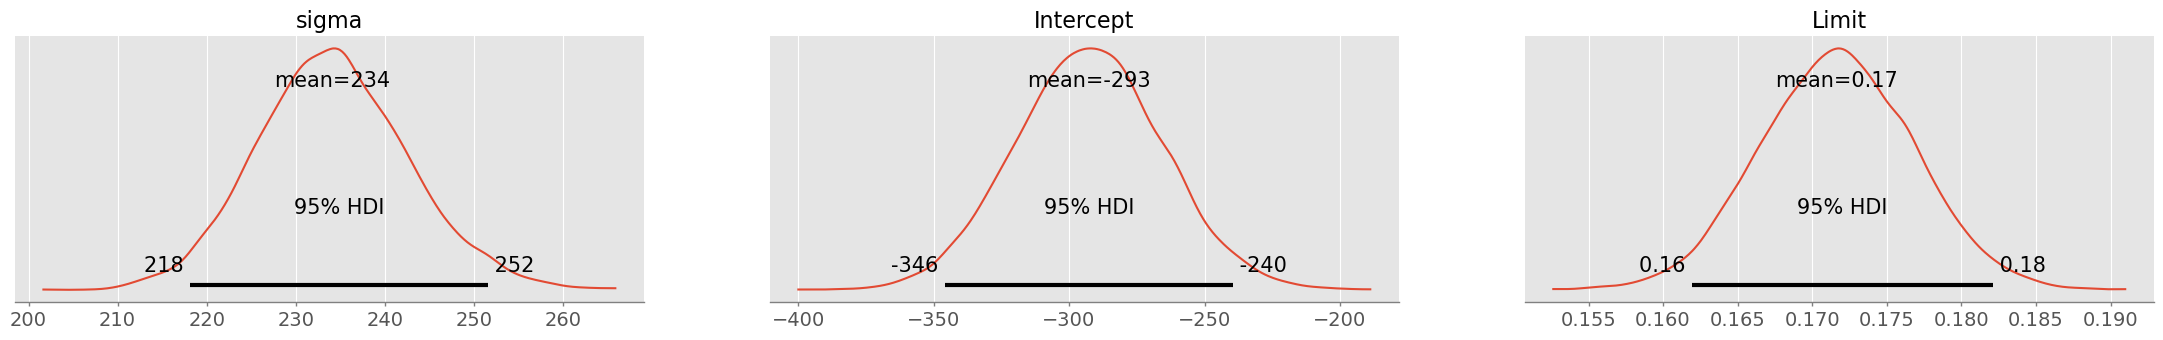

In [7]:
pm.plot_posterior( credit_trace1, hdi_prob=0.95 )

Mean model: 

$$\text{Balance} = -293 + 0.17 \cdot \text{Limit}$$

Interpretation: For every USD by that the limit is increased, the customer has 17 cents more debts. However the model does probably not hold for small balances and limits: for a limit of 0, the balance would be -293 USD (intercept). This is probably due to non-linearity.

### d)

Default computed for conditional variable: Limit


(<Figure size 800x300 with 1 Axes>,
 array([<Axes: xlabel='Limit', ylabel='Balance'>], dtype=object))

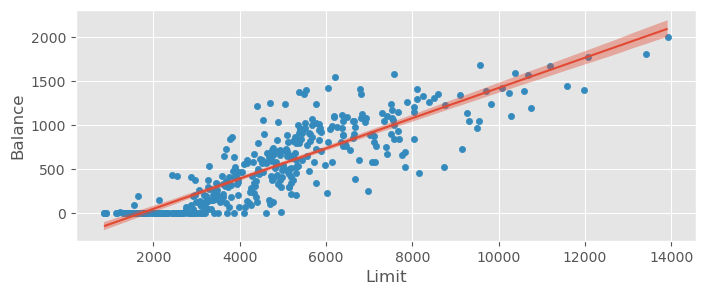

In [8]:
credit_data.plot.scatter( x="Limit", y="Balance" )
bmb.interpret.plot_predictions( credit_model1, credit_trace1, "Limit", prob=0.95, ax=plt.gca() )

The non-linearity in the beginning is clearly visible, leading to a compensation of the model with a negative intercept.

The epistemic uncertainty is quite small in comparison with the aleatoric certainty (unexplained variance in the data after fitting the model).

### e)

In [9]:
credit_model1.predict(credit_trace1, kind="response")
ypred = az.extract( credit_trace1.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values

RMSE:

In [10]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(330.7474098511541)

Given the credit card limit, we are able to model the balance by $\pm$ 331 USD.

MAE:

In [11]:
np.mean( np.abs( ypred - ytrue ) )

np.float64(260.4780826723066)

MAE is quite a bit smaller, indicating the presence of points further away from the line than expected.

$R^2$:

In [12]:
pm.r2_score( ytrue, ypred )

r2        0.659406
r2_std    0.018883
dtype: float64

The model is doing reasonably well for just one predictor.

### f)

Compute predictive distribution:

In [13]:
pred = credit_model1.predict( credit_trace1, kind="response", data=pd.DataFrame({'Limit': [3000]}), inplace=False )
pm.summary( pred.posterior_predictive, hdi_prob=0.9 )

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Balance[0],221.471,232.853,-141.329,613.565,2.745,1.787,7191.0,7869.0,1.0


<Axes: title={'center': 'Balance\n0'}>

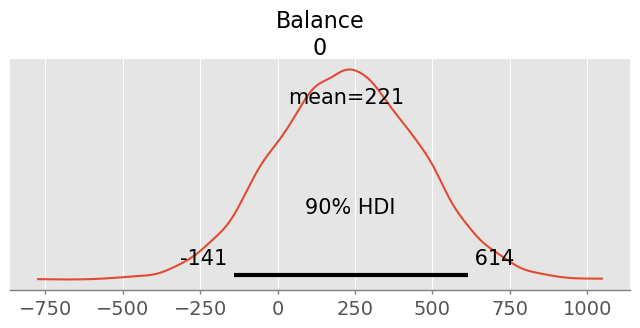

In [14]:
pm.plot_posterior( pred.posterior_predictive, hdi_prob=0.9 )

With a probability of 90%, the balance will be between -153 and 618 USD. This is clearly an artefact of a 'wrong' likelihood model (normal), since balance (debts) cannot be negative.

In [15]:
var_e = pred.posterior.mu.var().values
var_p = pred.posterior_predictive.Balance.var().values
var_a = var_p - var_e
np.sqrt( var_a ), np.sqrt( var_e ), np.sqrt( var_p )

(np.float64(232.36122763552714),
 np.float64(14.903739211518685),
 np.float64(232.8387028626775))

Ratios:

In [16]:
var_e/var_p, var_a/var_p

(np.float64(0.004097133761204795), np.float64(0.9959028662387952))

Most of the uncertainty is of aleatoric nature! Collecting more data will not make the model better.

## Exercise 2

### a)

In [17]:
x = credit_data.Limit
y_obs = credit_data.Balance

with pm.Model() as credit_model2:
    # priors
    beta0 = pm.Normal('beta0', mu=credit_data.Balance.mean(), sigma=10 )
    beta1 = pm.Normal('beta1', mu=0, sigma=10 )
    sigma = pm.Exponential('sigma', lam=1/10 )

    # likelihood
    y = pm.TruncatedNormal('y', mu=beta0+beta1*x, lower=0, upper=2000, sigma=sigma, observed=y_obs )

    # simulate posterior
    credit_trace2 = pm.sample( 2000 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


### b)

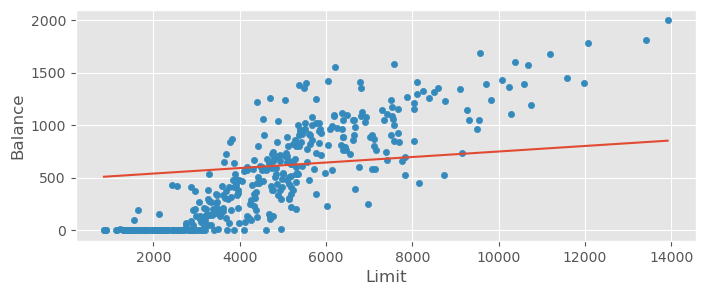

In [18]:
mean_beta0 = credit_trace2.posterior.beta0.mean().values
mean_beta1 = credit_trace2.posterior.beta1.mean().values
xrange = np.linspace( credit_data.Limit.min(), credit_data.Limit.max(), 1000 )

credit_data.plot.scatter( x="Limit", y="Balance" )
plt.plot( xrange, mean_beta0 + mean_beta1 * xrange )

Even though the model does not produce negative values anymore, it's bias is now too strong! The visible trend cannot be fitted. This model should definitely not be used.

## Exercise 3

### a)

In [19]:
insurance_data = pd.read_csv("insurance.csv")
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<Axes: xlabel='age', ylabel='charges'>

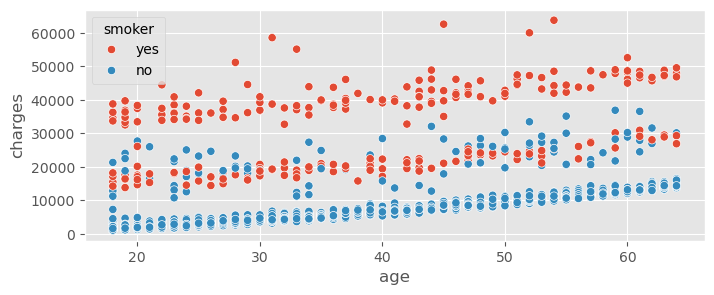

In [20]:
sns.scatterplot( data=insurance_data, x="age", y="charges", hue="smoker" )

<Axes: xlabel='bmi', ylabel='charges'>

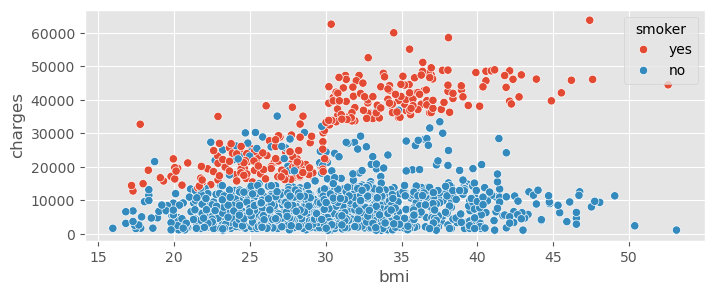

In [21]:
sns.scatterplot( data=insurance_data, x="bmi", y="charges", hue="smoker" )

Smoker is clearly a very important variable!

### b)

In [22]:
insurance_model1 = bmb.Model("charges ~ age + bmi + smoker", data=insurance_data, family="gaussian")
insurance_trace1 = insurance_model1.fit(draws=2000, tune=2000)
pm.summary( insurance_trace1, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, bmi, smoker]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,6097.166,116.990,5871.555,6328.900,1.020,1.294,13195.0,6492.0,1.0
Intercept,-11677.835,939.212,-13538.277,-9858.087,7.990,10.489,13905.0,6020.0,1.0
age,259.739,12.124,235.814,283.800,0.107,0.135,12861.0,6467.0,1.0
bmi,322.420,27.422,270.796,377.918,0.235,0.308,13692.0,6550.0,1.0
smoker[yes],23818.053,413.977,22954.620,24570.534,3.630,4.246,12962.0,6906.0,1.0


All parameters are significant at the 95% level (no HDI includes zero). The model can be interpreted as follows: Each year of age results in a mean of 260 USD of additional charges, a BMI increase of 1 results in a mean of additional 322 USD of charges and smokers have on average 23'800 USD more insurance charges than non-smokers!

In [23]:
insurance_model1.predict(insurance_trace1, kind="response")
ypred = az.extract( insurance_trace1.posterior_predictive ).charges.values.T
ytrue = insurance_data.charges.values

RMSE:

In [24]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(8621.337788653796)

Our predictions will typically be away from the ground truth by $\pm$ 8600 USD!

$R^2$:

In [25]:
pm.r2_score( ytrue, ypred )

r2        0.663960
r2_std    0.010121
dtype: float64

There is still a lot of variance to be explained!

### c)

In [26]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [27]:
insurance_model2 = bmb.Model("charges ~ age + sex + bmi + children + smoker + region", data=insurance_data, family="gaussian")
insurance_trace2 = insurance_model2.fit(draws=2000, tune=2000)
pm.summary( insurance_trace2, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, sex, bmi, children, smoker, region]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,6066.852,119.514,5843.446,6309.108,1.138,1.337,11047.0,6297.0,1.0
Intercept,-11930.846,1003.134,-13845.433,-9941.313,9.143,11.140,12050.0,6511.0,1.0
age,256.660,11.782,233.789,279.982,0.115,0.140,10459.0,5920.0,1.0
sex[male],-126.585,334.531,-792.728,525.869,3.167,3.889,11162.0,5542.0,1.0
bmi,339.247,28.686,284.907,397.107,0.274,0.304,10914.0,6013.0,1.0
children,475.135,136.997,199.021,731.831,1.290,1.448,11285.0,6273.0,1.0
smoker[yes],23843.799,415.643,23018.124,24660.363,3.918,4.487,11222.0,6546.0,1.0
region[northwest],-354.510,465.388,-1248.272,570.162,4.982,4.610,8723.0,6159.0,1.0
region[southeast],-1041.581,473.471,-2000.666,-150.520,5.147,4.663,8471.0,6550.0,1.0
region[southwest],-960.043,469.480,-1912.641,-91.691,5.065,4.810,8580.0,5957.0,1.0


Sex and region[northwest] do not contribute significantly at the 95% level (HDIs include zero).

Performance metrics:

In [28]:
insurance_model2.predict(insurance_trace2, kind="response")
ypred = az.extract( insurance_trace2.posterior_predictive ).charges.values.T
ytrue = insurance_data.charges.values

RMSE:

In [29]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(8578.626184138278)

$R^2$:

In [30]:
pm.r2_score( ytrue, ypred )

r2        0.666538
r2_std    0.010132
dtype: float64

The improvement in terms of metrics is marginal. Rather use the more simple model from b) for this data! 

### d)

Compute model predictions:

In [31]:
pred = insurance_model2.predict( insurance_trace2, kind="response", data=insurance_data, inplace=False )

Compute different uncertainties (see lecture):

In [32]:
var_e = pred.posterior.mu.var().values
np.sqrt( var_e )

np.float64(10499.037071488348)

In [33]:
var_p = pred.posterior_predictive.charges.var().values
np.sqrt( var_p )

np.float64(12125.139005403647)

In [34]:
var_a = var_p - var_e
np.sqrt( var_a )

np.float64(6065.411484134803)

In [35]:
var_e / var_p, var_a / var_p

(np.float64(0.749765557528311), np.float64(0.25023444247168897))

There is a significant part of epistemic uncertainty! With more data we might thus also be able to use a model with more predictors (emphasis on might).

### e)

In [36]:
insurance_model3 = bmb.Model("charges ~ age + bmi + smoker + bmi:smoker", data=insurance_data, family="gaussian")
insurance_trace3 = insurance_model3.fit(draws=2000, tune=2000)
pm.summary( insurance_trace3, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, bmi, smoker, bmi:smoker]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,4911.809,95.349,4732.560,5103.148,1.044,1.188,8341.0,5423.0,1.0
Intercept,-2313.432,843.889,-4053.072,-708.409,10.486,10.016,6474.0,5542.0,1.0
age,266.625,9.696,248.509,286.376,0.117,0.116,6897.0,5490.0,1.0
bmi,8.019,25.295,-40.110,59.025,0.349,0.285,5236.0,5470.0,1.0
smoker[yes],-20049.028,1663.959,-23314.664,-16796.946,29.466,20.226,3192.0,4006.0,1.0
bmi:smoker[yes],1429.390,53.259,1326.506,1536.472,0.937,0.634,3232.0,3983.0,1.0


The interaction term is significant (and large), let's keep it if the predicitive performance increases as well:

In [37]:
insurance_model3.predict(insurance_trace3, kind="response")
ypred = az.extract( insurance_trace3.posterior_predictive ).charges.values.T
ytrue = insurance_data.charges.values
pm.r2_score( ytrue, ypred )

r2        0.752790
r2_std    0.008084
dtype: float64

A very significant improvement by almost 9% in explained variance! This is a clear indicator that this interaction term cannot be neglected when doing predictions.

### f)

<Axes: xlabel='bmi', ylabel='charges'>

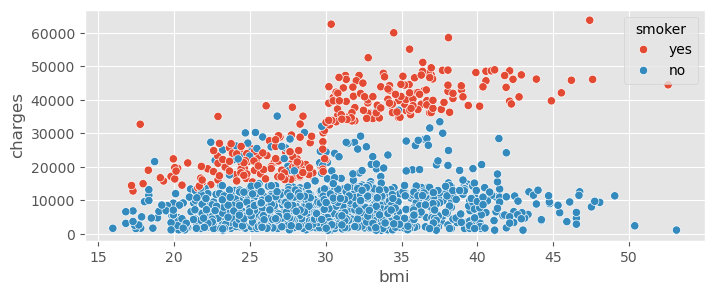

In [38]:
sns.scatterplot( data=insurance_data, x="bmi", y="charges", hue="smoker" )

The dependence of charges on BMI is much steeper if the client is a smoker!

## Exercise 4

### a)

In [39]:
adv_data = pd.read_csv("advertising.csv")
adv_data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


<Axes: xlabel='TV', ylabel='sales'>

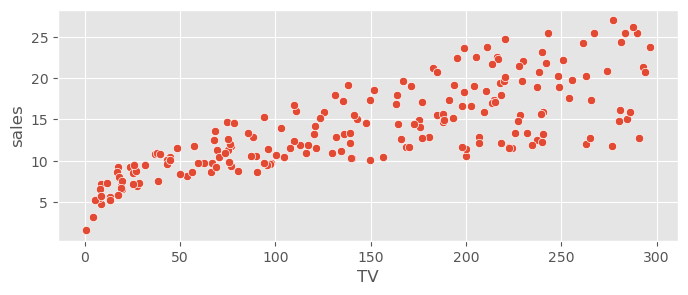

In [40]:
sns.scatterplot( data=adv_data, x="TV", y="sales" )

<Axes: xlabel='radio', ylabel='sales'>

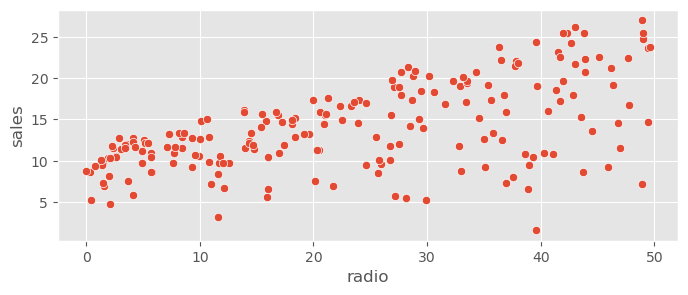

In [41]:
sns.scatterplot( data=adv_data, x="radio", y="sales" )

<Axes: xlabel='newspaper', ylabel='sales'>

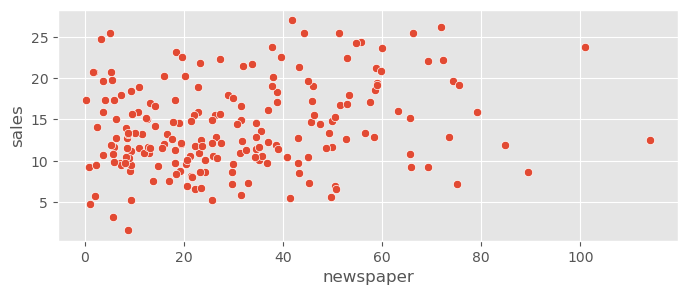

In [42]:
sns.scatterplot( data=adv_data, x="newspaper", y="sales" )

Expect contributions by radio and TV, probably not by newspaper.

### b)

In [43]:
adv_model1 = bmb.Model("sales ~ TV + radio + newspaper", data=adv_data, family="gaussian")
adv_trace1 = adv_model1.fit(draws=2000, tune=2000)
pm.summary( adv_trace1, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, newspaper]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.696,0.087,1.537,1.875,0.001,0.001,11637.0,6564.0,1.0
Intercept,2.932,0.315,2.304,3.535,0.003,0.003,12480.0,6872.0,1.0
TV,0.046,0.001,0.043,0.048,0.000,0.000,9719.0,6600.0,1.0
radio,0.189,0.009,0.170,0.205,0.000,0.000,9011.0,6908.0,1.0
newspaper,-0.001,0.006,-0.013,0.011,0.000,0.000,8996.0,6755.0,1.0


The 95\% HDI for newspaper includes zero, thus newspaper does not contribute significantly at the 95% level. For each 1000 USD spent on TV ads, 46 more units are sold (43-49 in 95% HDI), for each 1000 USD spent on radio ads, 189 more units are sold (172-205 in 95% HDI).

### c)

In [44]:
adv_model1.predict(adv_trace1, kind="response")
ypred = az.extract( adv_trace1.posterior_predictive ).sales.values.T
ytrue = adv_data.sales.values

RMSE:

In [45]:
rmse = np.sqrt( np.mean( (ypred - ytrue)**2 ) )
rmse

np.float64(2.392592625451304)

In [46]:
rmse / np.mean(adv_data.sales)

np.float64(0.17062525408816573)

Our predictions will typically be away from the true value by $\pm$ 2400 sold units, this is about 20% of the units being typically sold. For the advertisement business I wouldn't expect much more..

$R^2$:

In [47]:
pm.r2_score( ytrue, ypred )

r2        0.826892
r2_std    0.015734
dtype: float64

### d)

In [48]:
adv_model2 = bmb.Model("sales ~ TV + radio", data=adv_data, family="gaussian")
adv_trace2 = adv_model2.fit(draws=2000, tune=2000)
pm.summary( adv_trace2, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.691,0.085,1.527,1.860,0.001,0.001,11014.0,6841.0,1.0
Intercept,2.917,0.292,2.348,3.490,0.003,0.003,13175.0,5954.0,1.0
TV,0.046,0.001,0.043,0.049,0.000,0.000,11338.0,6458.0,1.0
radio,0.188,0.008,0.172,0.204,0.000,0.000,12633.0,6971.0,1.0


In [49]:
adv_model2.predict(adv_trace2, kind="response")
ypred = az.extract( adv_trace2.posterior_predictive ).sales.values.T
ytrue = adv_data.sales.values

RMSE:

In [50]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(2.386114969682464)

$R^2$:

In [51]:
pm.r2_score( ytrue, ypred )

r2        0.827571
r2_std    0.015798
dtype: float64

No significant changes in RMSE or $R^2$.

### e)

In [52]:
adv_model3 = bmb.Model("sales ~ TV + radio + TV:radio", data=adv_data, family="gaussian")
adv_trace3 = adv_model3.fit(draws=2000, tune=2000)
pm.summary( adv_trace3, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, TV:radio]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.949,0.049,0.858,1.048,0.001,0.001,6564.0,4812.0,1.0
Intercept,6.750,0.251,6.269,7.233,0.004,0.003,3289.0,4348.0,1.0
TV,0.019,0.002,0.016,0.022,0.000,0.000,3256.0,4474.0,1.0
radio,0.029,0.009,0.012,0.047,0.000,0.000,3005.0,4204.0,1.0
TV:radio,0.001,0.000,0.001,0.001,0.000,0.000,2801.0,3793.0,1.0


The interaction term is significant and positive - meaning that if TV and radio are high, the amount of sales is even higher (synergy).

Predictive performance:

In [53]:
adv_model3.predict(adv_trace3, kind="response")
ypred = az.extract( adv_trace3.posterior_predictive ).sales.values.T
ytrue = adv_data.sales.values

RMSE:

In [54]:
rmse = np.sqrt( np.mean( (ypred - ytrue)**2 ) )
rmse

np.float64(1.3383383616612556)

In [55]:
rmse / adv_data.sales.mean()

np.float64(0.09544220799866326)

Our predictions will now typically be away from the true value by only $\pm$ 1300 sold units! this is about 10% of the units being typically sold! This is good..

$R^2$:

In [56]:
pm.r2_score( ytrue, ypred )

r2        0.938312
r2_std    0.006006
dtype: float64

A large part of the variance is now explained.

### f)

In [57]:
adv_data['logsales'] = np.log( adv_data.sales )
adv_data.head()

,TV,radio,newspaper,sales,logsales
0,230.1,37.8,69.2,22.1,3.095578
1,44.5,39.3,45.1,10.4,2.341806
2,17.2,45.9,69.3,9.3,2.230014
3,151.5,41.3,58.5,18.5,2.917771
4,180.8,10.8,58.4,12.9,2.557227


<Axes: xlabel='TV', ylabel='logsales'>

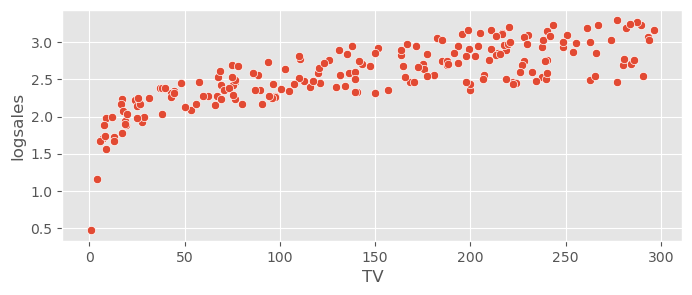

In [58]:
sns.scatterplot( data=adv_data, x="TV", y="logsales", )

<Axes: xlabel='radio', ylabel='logsales'>

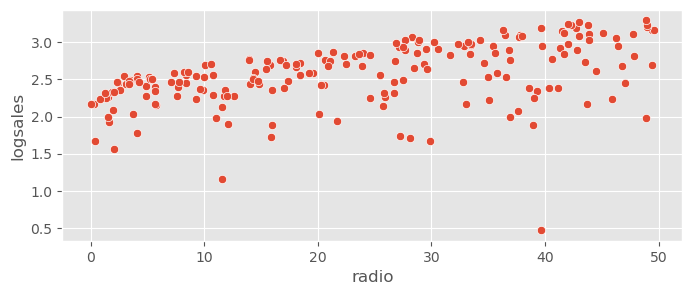

In [59]:
sns.scatterplot( data=adv_data, x="radio", y="logsales" )

<Axes: xlabel='newspaper', ylabel='logsales'>

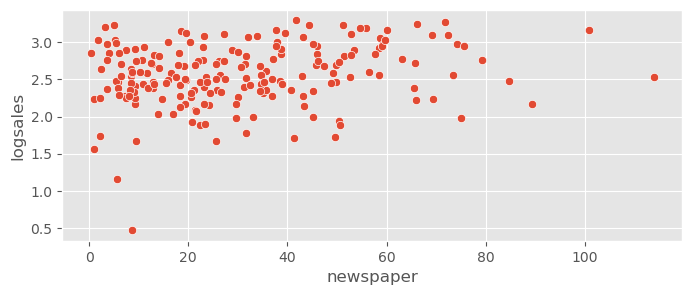

In [60]:
sns.scatterplot( data=adv_data, x="newspaper", y="logsales" )

The variance is now more constant along the predictors, however the residuals look a bit more skewed now. Let's check how this works!

In [61]:
adv_model4 = bmb.Model("logsales ~ TV + radio + TV:radio", data=adv_data, family="gaussian")
adv_trace4 = adv_model4.fit(draws=2000, tune=2000)
pm.summary( adv_trace4, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, TV:radio]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 4 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.177,0.009,0.160,0.195,0.000,0.000,6129.0,4903.0,1.0
Intercept,1.915,0.047,1.823,2.006,0.001,0.001,3102.0,3909.0,1.0
TV,0.002,0.000,0.002,0.003,0.000,0.000,2812.0,3928.0,1.0
radio,0.005,0.002,0.002,0.008,0.000,0.000,2927.0,3914.0,1.0
TV:radio,0.000,0.000,0.000,0.000,0.000,0.000,2629.0,3659.0,1.0


Predictive performance:

In [62]:
adv_model4.predict(adv_trace4, kind="response")
ypred = np.exp( az.extract( adv_trace4.posterior_predictive ).logsales.values.T )
ytrue = adv_data.sales.values

RMSE:

In [63]:
rmse = np.sqrt( np.mean( (ypred - ytrue)**2 ) )
rmse

np.float64(3.2639485089464157)

In [64]:
rmse / adv_data.sales.mean()

np.float64(0.23276509245472743)

$R^2$:

In [65]:
pm.r2_score( ytrue, ypred )

r2        0.796211
r2_std    0.017985
dtype: float64

The model performs much worse. Probably because we violated the assumption of normally distributed residuals.

## Exercise 5

### a)

In [66]:
bodyfat_data = pd.read_csv("bodyfat.csv")
bodyfat_data.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
0,1.0708,12.3,23,70.0,172.1,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.6
1,1.0853,6.1,22,78.6,183.5,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.3
2,1.0414,25.3,22,69.9,168.3,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.7
3,1.0751,10.4,26,83.8,183.5,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.9
4,1.0340,28.7,24,83.6,181.0,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.5


<Axes: xlabel='BMI', ylabel='BodyFat'>

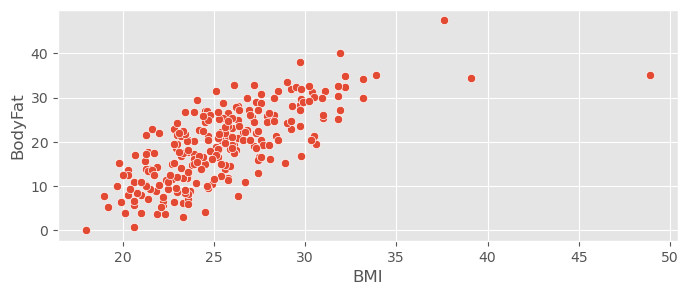

In [67]:
sns.scatterplot( bodyfat_data, x="BMI", y="BodyFat" )

### b)

In [68]:
bodyfat_model1 = bmb.Model("BodyFat ~ BMI", data=bodyfat_data, family="gaussian")
bodyfat_trace1 = bodyfat_model1.fit(draws=2000, tune=2000)
pm.summary( bodyfat_trace1, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,5.774,0.260,5.283,6.288,0.002,0.003,11866.0,6220.0,1.0
Intercept,-22.896,2.543,-27.579,-17.531,0.022,0.028,12819.0,6351.0,1.0
BMI,1.654,0.099,1.450,1.840,0.001,0.001,12308.0,6128.0,1.0


Plot:

Default computed for conditional variable: BMI


(<Figure size 800x300 with 1 Axes>,
 array([<Axes: xlabel='BMI', ylabel='BodyFat'>], dtype=object))

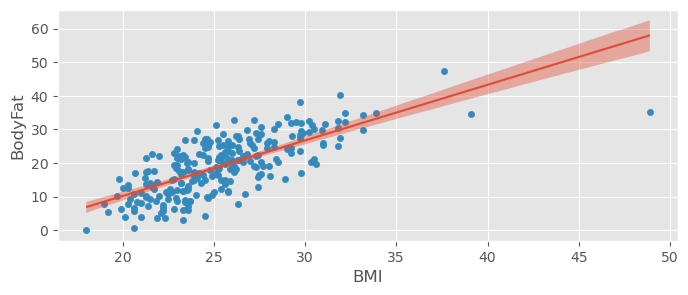

In [69]:
bodyfat_data.plot.scatter( x="BMI", y="BodyFat" )
bmb.interpret.plot_predictions( bodyfat_model1, bodyfat_trace1, "BMI", prob=0.95, ax=plt.gca() )

Predictive performance:

In [70]:
bodyfat_model1.predict(bodyfat_trace1, kind="response")
ypred = az.extract( bodyfat_trace1.posterior_predictive ).BodyFat.values.T
ytrue = bodyfat_data.BodyFat.values

RMSE:

In [71]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(8.151465963173502)

Our predictions will now typically be away from the true value by around $\pm$ 8%.

$R^2$:

In [72]:
pm.r2_score( ytrue, ypred )

r2        0.513199
r2_std    0.027314
dtype: float64

There are better $R^2$ values in the world..

### c)

In [73]:
bodyfat_model2 = bmb.Model("BodyFat ~ BMI", data=bodyfat_data, family="t")
bodyfat_trace2 = bodyfat_model2.fit(draws=2000, tune=2000)
pm.summary( bodyfat_trace2, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,5.525,0.283,4.977,6.084,0.003,0.003,6717.0,5956.0,1.0
nu,26.547,13.361,6.689,52.875,0.157,0.199,6800.0,5675.0,1.0
Intercept,-24.806,2.819,-30.321,-19.225,0.031,0.029,8377.0,6308.0,1.0
BMI,1.731,0.111,1.500,1.939,0.001,0.001,8248.0,6281.0,1.0


Plot:

Default computed for conditional variable: BMI
Default computed for conditional variable: BMI


(<Figure size 800x300 with 1 Axes>,
 array([<Axes: xlabel='BMI', ylabel='BodyFat'>], dtype=object))

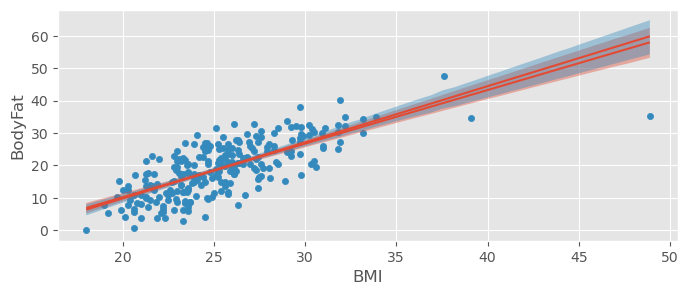

In [74]:
bodyfat_data.plot.scatter( x="BMI", y="BodyFat" )
bmb.interpret.plot_predictions( bodyfat_model1, bodyfat_trace1, "BMI", prob=0.95, ax=plt.gca() )
bmb.interpret.plot_predictions( bodyfat_model2, bodyfat_trace2, "BMI", prob=0.95, ax=plt.gca() )

Predictive performance:

In [75]:
bodyfat_model2.predict(bodyfat_trace2, kind="response")
ypred = az.extract( bodyfat_trace2.posterior_predictive ).BodyFat.values.T
ytrue = bodyfat_data.BodyFat.values

RMSE:

In [76]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(8.182406471636726)

Our predictions will now typically be away from the true value by around $\pm 8%$.

$R^2$:

In [77]:
pm.r2_score( ytrue, ypred )

r2        0.524749
r2_std    0.027579
dtype: float64

Only very slight improvement! Probably better prefer the simpler model.

### d)

Compute log likelihoods:

In [78]:
with bodyfat_model1.backend.model:
    pm.compute_log_likelihood( bodyfat_trace1 )

with bodyfat_model2.backend.model:
    pm.compute_log_likelihood( bodyfat_trace2 )

Output()

Output()

Compare ELPDs:

In [79]:
compare_dict = {
    'Normal model': bodyfat_trace1, 
    'Robust model': bodyfat_trace2 
}
comp = pm.compare( compare_dict )
comp

/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Robust model,0,-5955.883625,2078.364114,0.000000,1.000000e+00,69.720592,0.000000,True,log
Normal model,1,-9954.396132,4018.768428,3998.512507,1.110223e-14,159.986916,90.431108,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

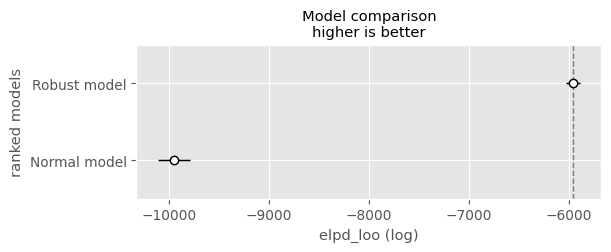

In [80]:
pm.plot_compare( comp )

There seems to a big difference in terms of predictive performance. However both loo estimates produced warnings and our predictive performance estimates say otherwise. Personally, I would trust more in RMSE and $R^2$ here.

### e)

In [81]:
bodyfat_data.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BMI
0,1.0708,12.3,23,70.0,172.1,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1,23.6
1,1.0853,6.1,22,78.6,183.5,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2,23.3
2,1.0414,25.3,22,69.9,168.3,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6,24.7
3,1.0751,10.4,26,83.8,183.5,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2,24.9
4,1.0340,28.7,24,83.6,181.0,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7,25.5


In [82]:
bodyfat_model3 = bmb.Model(
    "BodyFat ~ Age + Weight + Height + Neck + Chest + Abdomen + Hip + Thigh + Knee + Ankle + Biceps + Forearm + Wrist + BMI", 
    data=bodyfat_data, 
    family="t"
)
bodyfat_trace3 = bodyfat_model3.fit(draws=2000, tune=2000)
pm.summary( bodyfat_trace3, hdi_prob=0.95 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, Age, Weight, Height, Neck, Chest, Abdomen, Hip, Thigh, Knee, Ankle, Biceps, Forearm, Wrist, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 24 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,4.152,0.206,3.776,4.574,0.002,0.002,9917.0,5681.0,1.0
nu,32.525,15.211,9.499,62.965,0.148,0.226,11537.0,6283.0,1.0
Intercept,-142.532,52.377,-242.526,-35.642,0.792,0.593,4396.0,4762.0,1.0
Age,0.073,0.032,0.009,0.136,0.000,0.000,7903.0,6524.0,1.0
Weight,-0.943,0.319,-1.565,-0.304,0.005,0.004,4454.0,4882.0,1.0
Height,0.735,0.295,0.172,1.340,0.005,0.003,4028.0,4406.0,1.0
Neck,-0.473,0.233,-0.926,-0.019,0.002,0.003,10601.0,6117.0,1.0
Chest,-0.077,0.108,-0.291,0.130,0.001,0.001,8845.0,5557.0,1.0
Abdomen,0.899,0.091,0.720,1.072,0.001,0.001,8927.0,6249.0,1.0
Hip,-0.300,0.148,-0.584,-0.003,0.002,0.002,9723.0,6180.0,1.0


The uncertainty on $\nu$ is still quite large! Since it is large (mean of 33), probably a normal likelihood could be preferred.
The following variables do not seem to be significant at to 95% level: Neck, Chest, Thigh, Knee, Ankle, Biceps, Forearm. It might make sense to refit a model without them.

Predictions:

In [83]:
bodyfat_model3.predict(bodyfat_trace3, kind="response")
ypred = az.extract( bodyfat_trace3.posterior_predictive ).BodyFat.values.T
ytrue = bodyfat_data.BodyFat.values

RMSE:

In [84]:
np.sqrt( np.mean( (ypred - ytrue)**2 ) )

np.float64(6.068379228018641)

Our predictions will now typically be away from the true value by around $\pm 6%$, this is 25% better!

$R^2$:

In [85]:
pm.r2_score( ytrue, ypred )

r2        0.662684
r2_std    0.023387
dtype: float64

Quite a bit more variance explained!

## Exercise 6

### a)

Load data:

In [86]:
fuel_data = pd.read_csv("fuel_data.csv")
fuel_data

,t,tank_level,state
0,0,48.270,nominal
1,1,48.301,nominal
2,2,48.218,nominal
3,3,48.275,nominal
4,4,48.207,nominal
5,5,48.122,nominal
6,6,48.073,nominal
7,7,48.119,nominal
8,8,47.931,nominal
9,9,47.843,nominal


Plot:

<Axes: xlabel='t', ylabel='tank_level'>

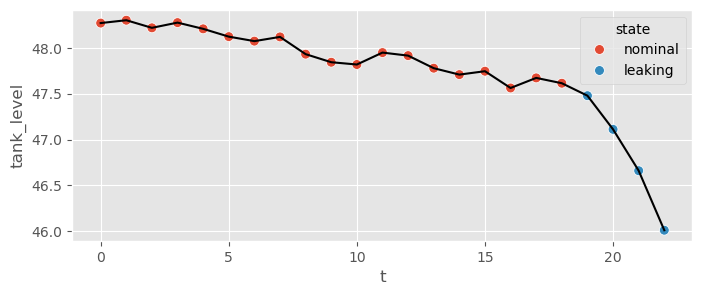

In [87]:
sns.lineplot( data=fuel_data, x="t", y="tank_level", c="black" )
sns.scatterplot( data=fuel_data, x="t", y="tank_level", hue="state", s=50 )

### b)

Prior for intercept:

<Axes: >

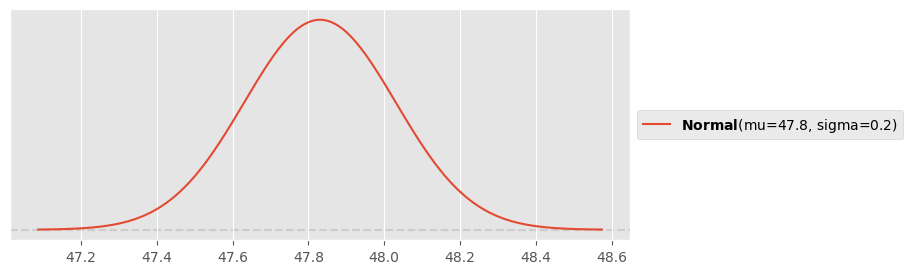

In [88]:
y0 = (fuel_data.tank_level[9]+fuel_data.tank_level[10])/2
pz.Normal(y0, 0.2).plot_pdf()

Prior for regular fuel decrease:

<Axes: >

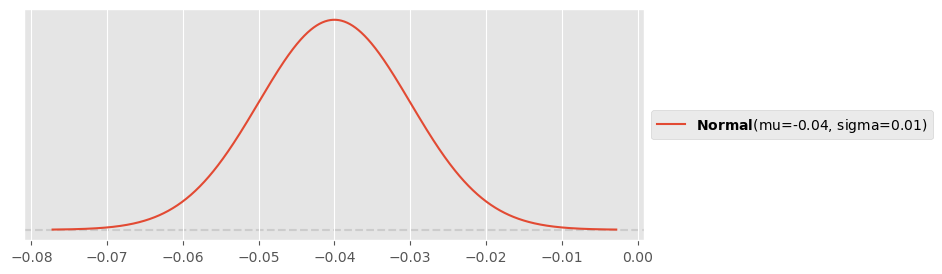

In [89]:
pz.Normal(-0.04, 0.01).plot_pdf()

Fit model:

In [90]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=y0, sigma=0.2),
    "t": bmb.Prior("Normal", mu=-0.04, sigma=0.01), 
}
normal_tank_model = bmb.Model("tank_level ~ t", data=fuel_data[fuel_data.t <= 19], priors=priors, family="gaussian")
normal_tank_trace = normal_tank_model.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, t]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Default computed for conditional variable: t


(<Figure size 800x300 with 1 Axes>,
 array([<Axes: xlabel='t', ylabel='tank_level'>], dtype=object))

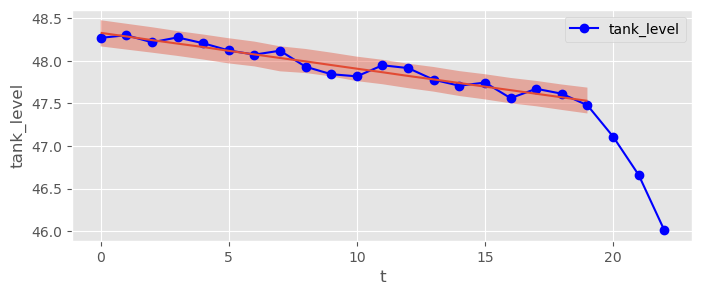

In [91]:
fuel_data.plot( x="t", y="tank_level", marker="o", c="blue" )
bmb.interpret.plot_predictions( normal_tank_model, normal_tank_trace, "t", prob=0.95, pps=True, ax=plt.gca() )

In [92]:
pm.summary( normal_tank_trace, hdi_prob=0.95 )

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.070,0.013,0.048,0.095,0.0,0.0,7908.0,5275.0,1.0
Intercept,48.328,0.030,48.269,48.388,0.0,0.0,9028.0,5409.0,1.0
t,-0.042,0.003,-0.047,-0.037,0.0,0.0,8895.0,5729.0,1.0


Typical fuel consumption between 37 and 47 $\mu g$ per day (95% HDI, results may vary slightly for different simulations).

### c)

In [93]:
fuel_data[fuel_data.t>=19]

,t,tank_level,state
19,19,47.478,leaking
20,20,47.111,leaking
21,21,46.660,leaking
22,22,46.011,leaking


In [94]:
leaking_tank_model = bmb.Model("tank_level ~ t", data=fuel_data[fuel_data.t>=19], family="gaussian")
leaking_tank_trace = leaking_tank_model.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, t]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Default computed for conditional variable: t


(<Figure size 800x300 with 1 Axes>,
 array([<Axes: xlabel='t', ylabel='tank_level'>], dtype=object))

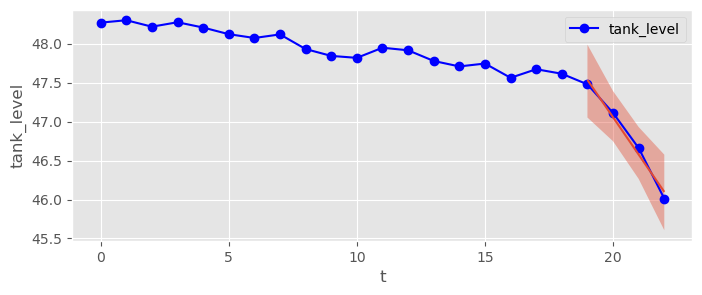

In [95]:
fuel_data.plot( x="t", y="tank_level", marker="o", c="blue" )
bmb.interpret.plot_predictions( leaking_tank_model, leaking_tank_trace, "t", prob=0.95, ax=plt.gca() )

In [96]:
pm.summary( leaking_tank_trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.225,0.189,0.044,0.545,0.005,0.010,1124.0,1580.0,1.0
Intercept,56.633,2.736,52.216,61.711,0.060,0.293,3752.0,2413.0,1.0
t,-0.479,0.133,-0.708,-0.246,0.003,0.014,3764.0,2415.0,1.0


fuel loss between 228 and 697 $\mu$g per day! (results may vary from simulation to simulation, will get better with more data)

### d)

In [97]:
t0 = fuel_data.tank_level[22] / np.abs( pm.hdi( leaking_tank_trace.posterior.t, 0.95 ) )
t0

<xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    t        (hdi) float64 16B 62.41 190.8

Between 63 and 232 days with a belief of 95%, however this is probably quite uncertain (especially if you re-run the simulation). You'll know more with more data!

Let us plot the distribution to better understand our uncertainty:

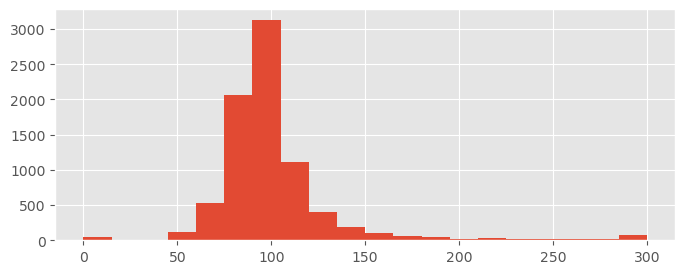

In [100]:
t0_values = -fuel_data.tank_level[22] / leaking_tank_trace.posterior.t.values.flatten()
plt.hist( t0_values.clip(0, 300), bins=20 );

(a few strong outliers - interesting exercise: find a good prior for $t$ to make them disappear)